# Import Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import math

from wordcloud import WordCloud, STOPWORDS

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
import tensorflow_hub as hub

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import pos_tag

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kmlee\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kmlee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kmlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kmlee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kmlee\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Import Dataset

In [15]:
DIR = "Womens Clothing E-Commerce Reviews.csv"
clothing_data = pd.read_csv(DIR, index_col=[0])
clothing_data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,918.118709,43.198544,4.196032,0.822362,2.535936
std,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


# Cleaning Dataset

In [16]:
# Checking which essential columns have missing data

clothing_data.isnull().sum() / len(clothing_data) * 100

Clothing ID                 0.000000
Age                         0.000000
Title                      16.222430
Review Text                 3.597888
Rating                      0.000000
Recommended IND             0.000000
Positive Feedback Count     0.000000
Division Name               0.059610
Department Name             0.059610
Class Name                  0.059610
dtype: float64

In [17]:
# Removing rows with essential missing data

clothing_data = clothing_data[~clothing_data['Review Text'].isnull()]
clothing_data = clothing_data[~clothing_data['Division Name'].isnull()]
clothing_data.isnull().sum()/len(clothing_data)*100

Clothing ID                 0.000000
Age                         0.000000
Title                      13.107654
Review Text                 0.000000
Rating                      0.000000
Recommended IND             0.000000
Positive Feedback Count     0.000000
Division Name               0.000000
Department Name             0.000000
Class Name                  0.000000
dtype: float64

In [18]:
clothing_data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# Exploratory Data Analysis (EDA)

Categories of clothes by department

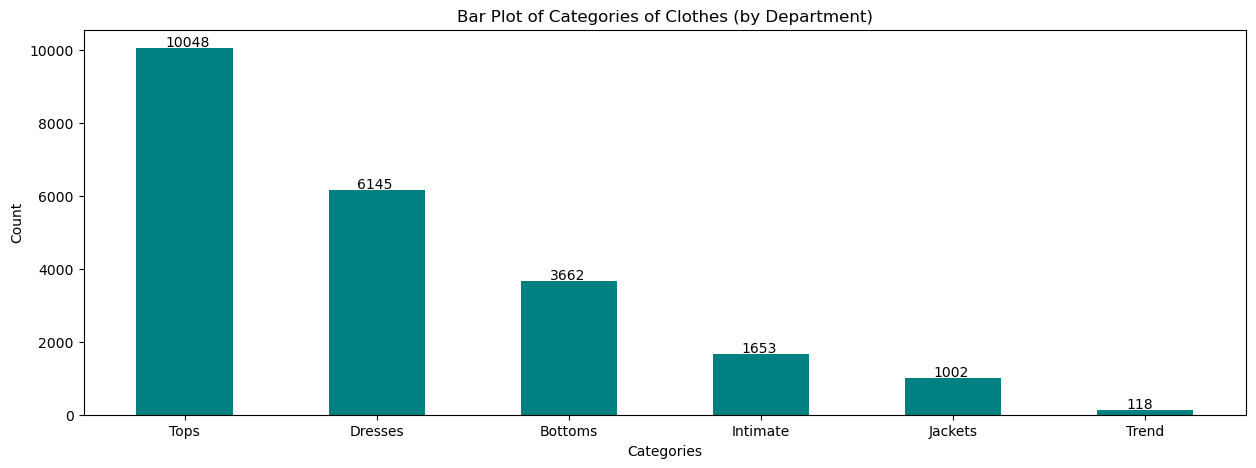

In [19]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

categories = clothing_data['Department Name'].value_counts().index
counts = clothing_data['Department Name'].value_counts().values
ax.bar(categories, counts, width=0.5, color="teal")

ax.set_title("Bar Plot of Categories of Clothes (by Department)")
ax.set_xlabel("Categories")
ax.set_ylabel("Count")

for i in ax.patches:
  ax.text(i.get_x()+0.15, i.get_height() + 50, str(round(i.get_height())), fontsize = 10)

Word cloud

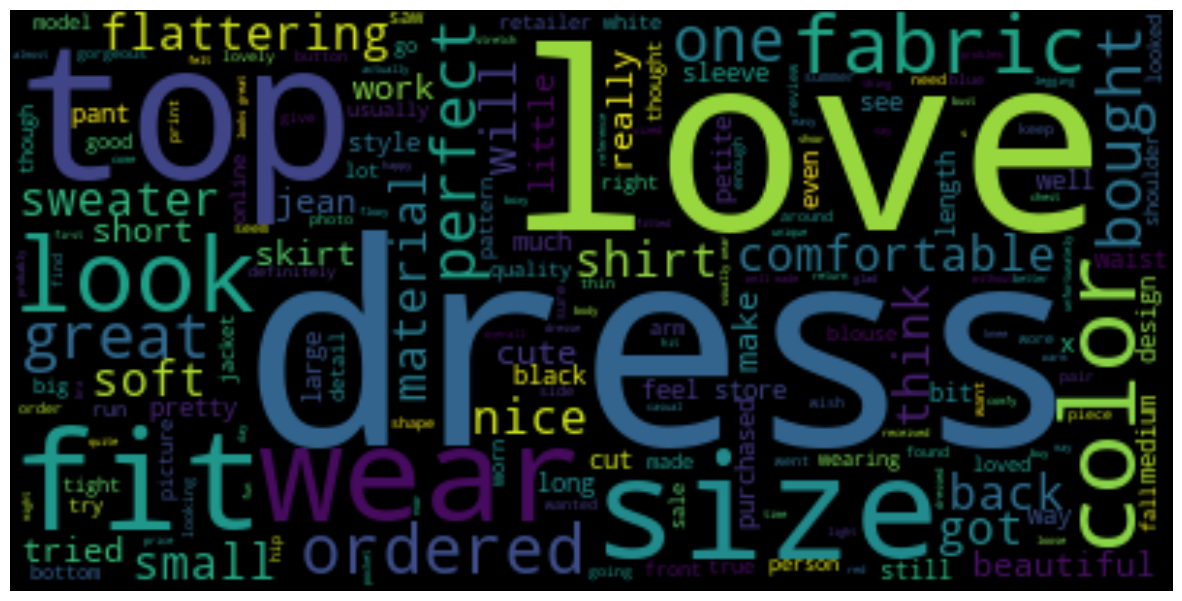

In [20]:
reviews = clothing_data['Review Text'].tolist()
reviews = ' '.join(reviews).lower()
wordcloud = WordCloud(stopwords = STOPWORDS, collocations=True).generate(reviews)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

Ratings and Recommended INDs

In [21]:
# Calculating mean and standard deviation 

dept_names = ['Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend']
avg_rating_by_dept = []
avg_ind_by_dept = []
std_rating_by_dept = []
std_ind_by_dept = []

for dept in dept_names:
  avg_rating_by_dept.append(clothing_data[clothing_data['Department Name'] == dept]['Rating'].mean())
  avg_ind_by_dept.append(clothing_data[clothing_data['Department Name'] == dept]['Recommended IND'].mean())
  std_rating_by_dept.append(clothing_data[clothing_data['Department Name'] == dept]['Rating'].std())
  std_ind_by_dept.append(clothing_data[clothing_data['Department Name'] == dept]['Recommended IND'].std())

C:\Users\kmlee\AppData\Local\Temp\ipykernel_6180\4266496711.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['null', 'Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend'])


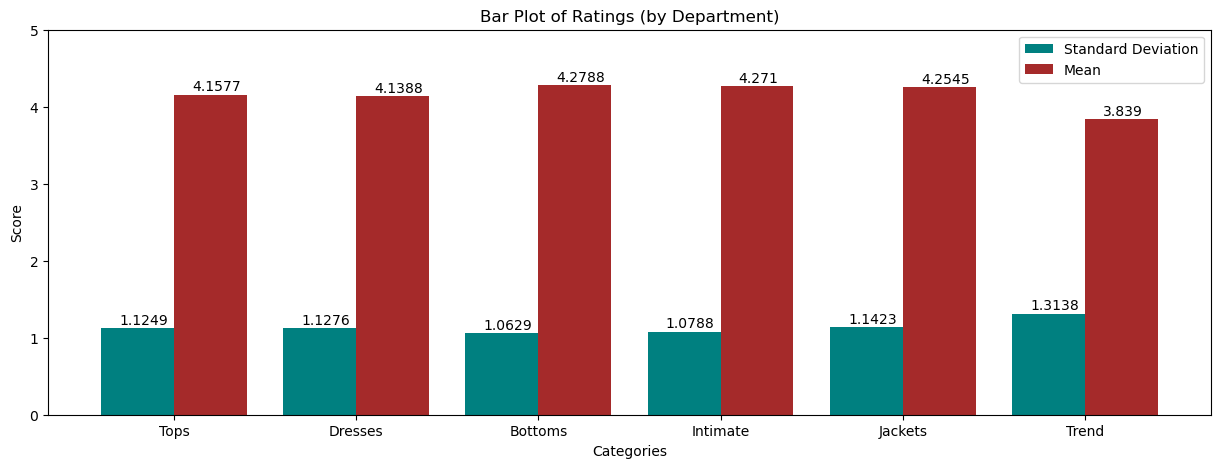

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

x = np.arange(6)
width = 0.4

ax.bar(x-0.2, std_rating_by_dept, width, color="teal")
ax.bar(x+0.2, avg_rating_by_dept, width, color="brown")

ax.set_title("Bar Plot of Ratings (by Department)")
ax.set_xlabel("Categories")
ax.set_ylabel("Score")
ax.set_xticklabels(['null', 'Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend'])
plt.yticks(np.arange(0,6,1))
ax.legend(['Standard Deviation', 'Mean'])

for i in ax.patches:
  ax.text(i.get_x()+0.1, i.get_height() + .05, str(round(i.get_height(),4)), fontsize = 10)

C:\Users\kmlee\AppData\Local\Temp\ipykernel_6180\2320153611.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['null', 'Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend'])


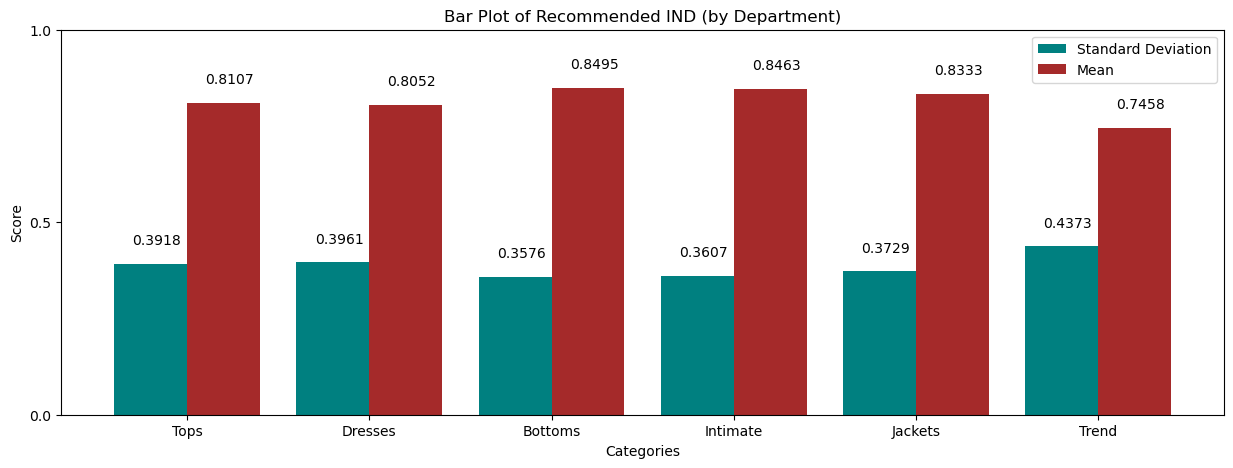

In [23]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

x = np.arange(6)
width = 0.4

ax.bar(x-0.2, std_ind_by_dept, width, color="teal")
ax.bar(x+0.2, avg_ind_by_dept, width, color="brown")

ax.set_title("Bar Plot of Recommended IND (by Department)")
ax.set_xlabel("Categories")
ax.set_ylabel("Score")
ax.set_xticklabels(['null', 'Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend'])
plt.yticks(np.arange(0,1.5,0.5))
ax.legend(['Standard Deviation', 'Mean'])

for i in ax.patches:
  ax.text(i.get_x()+0.1, i.get_height() + .05, str(round(i.get_height(),4)), fontsize = 10)

# Rating Strength

In [24]:
def rating_exp(x):
    return math.exp((np.mean(x.Rating)+1)*(np.mean(x['Recommended IND'])+1)/((np.std(x.Rating)+1)*(np.std(x['Recommended IND'])+1)))

In [25]:
data_grouped = clothing_data.copy()
exp_factor = data_grouped.groupby(['Clothing ID']).apply(rating_exp)
exp_factor = pd.DataFrame({'Exp Factor': exp_factor})
exp_factor['Clothing ID'] = exp_factor.index
exp_factor.index.name = None
exp_factor

,Exp Factor,Clothing ID
1,10.442751,1
2,22026.465795,2
3,162754.791419,3
4,162754.791419,4
5,162754.791419,5
...,...,...
1200,54.598150,1200
1202,354.997025,1202
1203,40.801395,1203
1204,1530.474862,1204


In [26]:
data_grouped = data_grouped.merge(exp_factor, how='left', on='Clothing ID')
data_grouped

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Exp Factor
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1530.474862
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,30.350995
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,20.565447
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,44.170108
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,15.558265
...,...,...,...,...,...,...,...,...,...,...,...
22623,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,17.602689
22624,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,23.918808
22625,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,17.602689
22626,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,8.912216


In [27]:
data_grouped['Rating Factor'] = (1-data_grouped['Exp Factor'])/(1+data_grouped['Exp Factor'])


In [28]:
scaler = MinMaxScaler()
data_grouped['Rating Strength'] = scaler.fit_transform(np.array(data_grouped['Rating Factor'] ** 2).reshape(-1,1))
data_grouped

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Exp Factor,Rating Factor,Rating Strength
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1530.474862,-0.998694,0.996412
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,30.350995,-0.936206,0.828627
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,20.565447,-0.907259,0.754575
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,44.170108,-0.955723,0.879867
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,15.558265,-0.879214,0.685050
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22623,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses,17.602689,-0.892489,0.717686
22624,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits,23.918808,-0.919739,0.786217
22625,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses,17.602689,-0.892489,0.717686
22626,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses,8.912216,-0.798229,0.496531


<AxesSubplot:ylabel='Density'>

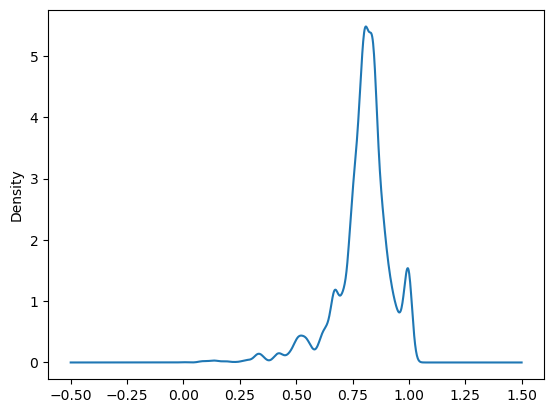

In [29]:
data_grouped['Rating Strength'].plot.density()

In [30]:
np.where(data_grouped["Rating Strength"] > 0.9)[0].size/len(clothing_data)

0.14150609863885452

In [31]:
data_grouped['Trending'] = np.where(data_grouped['Rating Strength']>0.9, 1, 0)
data_grouped.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Exp Factor,Rating Factor,Rating Strength,Trending
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1530.474862,-0.998694,0.996412,1
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,30.350995,-0.936206,0.828627,0
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,20.565447,-0.907259,0.754575,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,44.170108,-0.955723,0.879867,0
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,15.558265,-0.879214,0.685050,0


Text(0, 0.5, 'Percentage of Apparel')

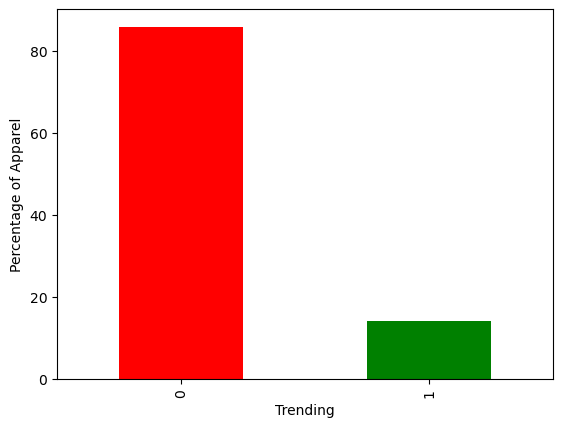

In [32]:
fig = data_grouped['Trending'].value_counts(normalize=True).mul(100).round(2).plot.bar(color=['r', 'g'])
plt.xlabel('Trending')
plt.ylabel('Percentage of Apparel')

In [33]:
mean_ratings = data_grouped.groupby('Clothing ID')['Rating'].mean()
sd_ratings = data_grouped.groupby('Clothing ID')['Rating'].std()

mean_reco_IND = data_grouped.groupby('Clothing ID')['Recommended IND'].mean()
sd_reco_IND = data_grouped.groupby('Clothing ID')['Recommended IND'].std()

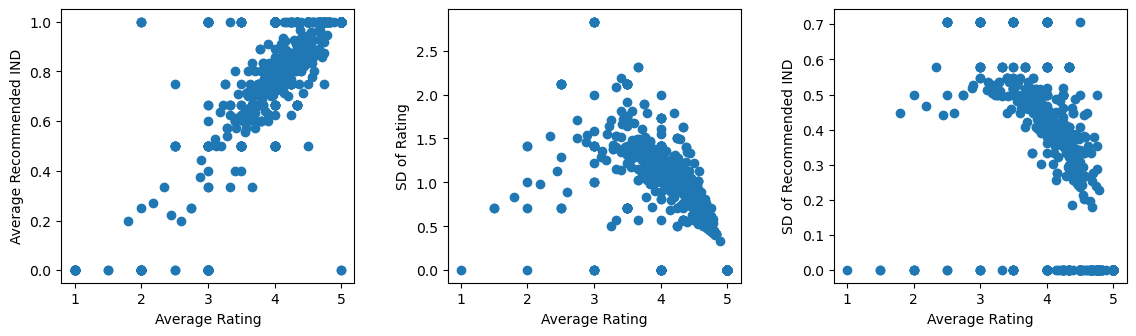

In [34]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

ax1.scatter(mean_ratings, mean_reco_IND)
ax1.set_xlabel('Average Rating')
ax1.set_ylabel('Average Recommended IND')

ax2.scatter(mean_ratings, sd_ratings)
ax2.set_xlabel('Average Rating')
ax2.set_ylabel('SD of Rating')

ax3.scatter(mean_ratings, sd_reco_IND)
ax3.set_xlabel('Average Rating')
ax3.set_ylabel('SD of Recommended IND')

fig.tight_layout(pad = 3)
plt.show()

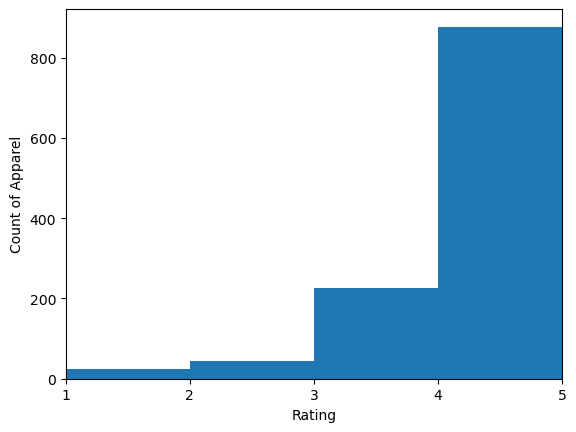

In [35]:
plt.hist(mean_ratings, bins=4)
plt.xlim((1,5))
plt.xticks(np.arange(1,6, step=1))
plt.xlabel('Rating')
plt.ylabel('Count of Apparel')
plt.show()

# Splitting Dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data_grouped[["Review Text"]], data_grouped["Trending"], test_size=0.2, random_state=42)

# Preprocess Corpus

In [37]:
# Remove punctuations

def remove_punctuation(text):
    return "".join([x for x in text if x not in string.punctuation])

In [38]:
# Tokenization

def tokenize_data(text): 
    return nltk.word_tokenize(text.lower())


In [39]:
# Remove stopwords

def remove_stopwords(tokens):
    stopwords = nltk.corpus.stopwords.words('english')
    return [word for word in tokens if word not in stopwords]


In [40]:
# Lemmatization

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]
    

In [41]:
# Stemming

def stem_tokens(tokens):
    ps = PorterStemmer()
    return [ps.stem(word) for word in tokens]


In [42]:
# POS Tagging

def pos_tagging(tokens):
    pos = pos_tag(tokens)
    return ["_".join(x) for x in pos]

In [43]:
def preprocess_corpus(data):
    # without punctuation
    data["Processed Text"] = data['Review Text'].apply(lambda x: remove_punctuation(x))
    data["Tokens"] = data["Processed Text"].apply(lambda x: tokenize_data(x))    
    data["Tokens"] = data["Tokens"].apply(lambda x: remove_stopwords(x))
    data["Tokens"] = data["Tokens"].apply(lambda x: lemmatize_tokens(x))
    data["Tokens"] = data["Tokens"].apply(lambda x: pos_tagging(x))
    return data

In [44]:
X_train = preprocess_corpus(X_train)
X_test = preprocess_corpus(X_test)

# Feature Extraction

In [45]:
# TfidfVectorizer (Word Level)

def dummy_func(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_func,
    preprocessor=dummy_func,
    token_pattern=None)

tfidf_X_train = tfidf.fit_transform(X_train['Tokens'])
tfidf_X_test = tfidf.transform(X_test['Tokens'])

# Helper Functions

In [46]:
# Function to evaluate predicition

def eval_preds(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    fbeta = fbeta_score(y_true, y_pred, beta=0.5, zero_division=0)
    print("Accuracy: {:.3f} \nPrecision: {:.3f} \nRecall: {:.3f} \nFbeta-score: {:.3f} \n".format(accuracy, precision, recall, fbeta))

In [47]:
# Function to evaluate classifier

global_threshold = 0.5

def evaluate_clf(clf, X, y, threshold):
    
    y_scores = clf.predict_proba(X)[:, 1]
    y_pred = (y_scores >= threshold).astype(int)
    
    # Classification report
    eval_preds(y, y_pred)

def get_optimal_threshold(clf, X, y, threshold):
    
    y_scores = clf.predict_proba(X)[:, 1]
    y_pred = (y_scores >= threshold).astype(int)
    
    eval_preds(y, y_pred)
    
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    # Convert to F_beta score
    beta_2 = 0.5 ** 2
    fscore = 0
    result = 0
    for thres in thresholds:
        if precision[i] == 0 and recall[i] == 0:
            continue
        temp_preds = (y_scores >= thres).astype(int)
        precision = precision_score(y, temp_preds)
        recall = recall_score(y, temp_preds)
        temp_score = ((1 + beta_2) * precision * recall) / (beta_2 * precision + recall)
        if temp_score > fscore:
            fscore = temp_score
            result = thres
    return result, fscore

# Base Models Training and Evaluation

**Logistic Regression Classifier**

In [38]:
# Training Logistic Regression Classifier

LR_clf = LogisticRegression()

LR_clf.fit(tfidf_X_train, y_train)

LogisticRegression()

In [48]:
# Evaluating Logistic Regression Classifier using train data

evaluate_clf(LR_clf, tfidf_X_train, y_train, global_threshold)

Accuracy: 0.869 
Precision: 0.894 
Recall: 0.088 
Fbeta-score: 0.317 



**Support Vector Classifier**

In [40]:
# Training Support Vector Classifier

SVC_clf = SVC(probability=True)

SVC_clf.fit(tfidf_X_train, y_train)

SVC(probability=True)

In [49]:
# Evaluating Support Vector Classifier using train data

evaluate_clf(SVC_clf, tfidf_X_train, y_train, global_threshold)

Accuracy: 0.995 
Precision: 0.997 
Recall: 0.968 
Fbeta-score: 0.991 



**Random Forest Classifier**

In [42]:
# Training Random Forest Classifier

RF_clf = RandomForestClassifier()

RF_clf.fit(tfidf_X_train, y_train)

RandomForestClassifier()

In [50]:
# Evaluating Random Forest Classifier using train data

evaluate_clf(RF_clf, tfidf_X_train, y_train, global_threshold)

Accuracy: 1.000 
Precision: 1.000 
Recall: 1.000 
Fbeta-score: 1.000 



**Multinomial Naive Bayes Classifier**

In [44]:
# Training Multinomial Naive Bayes Classifier

MNB_clf = MultinomialNB()

MNB_clf.fit(tfidf_X_train, y_train)

MultinomialNB()

In [51]:
# Evaluating Multinomial Naive Bayes Classifier using train data

evaluate_clf(MNB_clf, tfidf_X_train, y_train, global_threshold)

Accuracy: 0.858 
Precision: 1.000 
Recall: 0.002 
Fbeta-score: 0.008 



# GridSearchCV

In [46]:
# Helper function

def grid_search_helper(clf, grid):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
    grid_result = grid_search.fit(tfidf_X_train, y_train)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

In [47]:
# LR_clf = LogisticRegression(max_iter=1000)

# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# C = [100, 10, 1.0, 0.1, 0.01]

# grid = dict(solver=solvers, penalty=penalty, C=C)
# grid_search_helper(LR_clf, grid)

Best: 0.271227 using {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
* 0.271032 (0.023276) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
* 0.271227 (0.023269) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
* 0.270649 (0.023180) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
* 0.235928 (0.021770) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
* 0.235928 (0.021770) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
* 0.236182 (0.021705) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
* 0.065401 (0.013955) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
* 0.065412 (0.013952) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
* 0.065401 (0.013955) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
* 0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
* 0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
* 0.000000 (0.000000) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
* 0.000000 (0.000000) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
* 0.000000 (0.000000) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
* 0.000000 (0.000000) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [48]:
# SVC_clf = SVC()

# kernel = ['poly', 'rbf', 'sigmoid']
# C = [50, 10, 1.0, 0.1, 0.01]
# gamma = ['scale']

# grid = dict(kernel=kernel,C=C,gamma=gamma)

# grid_search_helper(SVC_clf, grid)


Best: 0.272116 using {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
* 0.009999 (0.004593) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
* 0.137425 (0.017700) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
* 0.272116 (0.019102) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
* 0.009999 (0.004593) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
* 0.137139 (0.017360) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
* 0.270971 (0.026004) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
* 0.004629 (0.004809) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
* 0.038832 (0.007814) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
* 0.082538 (0.015982) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
* 0.000000 (0.000000) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
* 0.000000 (0.000000) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
* 0.000000 (0.000000) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
* 0.000000 (0.000000) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'poly'}
* 0.000000 (0.000000) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
* 0.000000 (0.000000) with: {'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}

In [49]:
# RF_clf = RandomForestClassifier()

# n_estimators = [10, 100, 1000]
# max_features = ['sqrt', 'log2']

# grid = dict(n_estimators=n_estimators,max_features=max_features)

# grid_search_helper(RF_clf, grid)

Best: 0.076202 using {'max_features': 'sqrt', 'n_estimators': 10}
* 0.076202 (0.020912) with: {'max_features': 'sqrt', 'n_estimators': 10}
* 0.067104 (0.010694) with: {'max_features': 'sqrt', 'n_estimators': 100}
* 0.063821 (0.009840) with: {'max_features': 'sqrt', 'n_estimators': 1000}
* 0.016658 (0.009861) with: {'max_features': 'log2', 'n_estimators': 10}
* 0.005017 (0.003876) with: {'max_features': 'log2', 'n_estimators': 100}
* 0.004628 (0.004151) with: {'max_features': 'log2', 'n_estimators': 1000}

In [50]:
# MNB_clf = MultinomialNB()

# alpha = [1, 0.1, 0.001, 0.0001]

# grid = dict(alpha=alpha)

# grid_search_helper(MNB_clf, grid)

Best: 0.132958 using {'alpha': 0.001}
* 0.000000 (0.000000) with: {'alpha': 1}
* 0.089500 (0.010002) with: {'alpha': 0.1}
* 0.132958 (0.019463) with: {'alpha': 0.001}
* 0.127536 (0.018160) with: {'alpha': 0.0001}

# Model Tuning

**Logistic Regression Classifier**

In [51]:
# Training with optimal hyperparameters

LR_clf_tuned = LogisticRegression(C=100, penalty='l2', solver='lbfgs', max_iter=1000)

LR_clf_tuned.fit(tfidf_X_train, y_train)

LogisticRegression(C=100, max_iter=1000)

In [6]:
def print_dict(a, b, c, d):
    print("Accuracy: {:.3f} \nPrecision: {:.3f} \nRecall: {:.3f} \nFbeta-score: {:.3f} \n".format(a,b,c,d))

In [52]:
# Evaluating using train dataset and obtaining optimal threshold

evaluate_clf(LR_clf_tuned, tfidf_X_train, y_train, global_threshold)
optimal_threshold, fbeta = get_optimal_threshold(LR_clf_tuned, tfidf_X_train, y_train, global_threshold)
print(optimal_threshold, fbeta)

Accuracy: 0.869 
Precision: 0.894 
Recall: 0.088 
Fbeta-score: 0.317 

(0.8, 0.982)


In [53]:
# Evaluating on test dataset

evaluate_clf(LR_clf_tuned, tfidf_X_test, y_test, optimal_threshold)

Accuracy: 0.832 
Precision: 0.347 
Recall: 0.253 
Fbeta-score: 0.323 



**Support Vector Classifier**

In [54]:
# Training with optimal hyperparameters

SVC_clf_tuned = SVC(probability=True, C=50, gamma='scale', kernel='sigmoid')

SVC_clf_tuned.fit(tfidf_X_train, y_train)

SVC(C=50, kernel='sigmoid', probability=True)

In [54]:
# Evaluating using train dataset and obtaining optimal threshold

evaluate_clf(SVC_clf_tuned, tfidf_X_train, y_train, global_threshold)
optimal_threshold, fbeta = get_optimal_threshold(SVC_clf_tuned, tfidf_X_train, y_train, global_threshold)
print((optimal_threshold, fbeta))

Accuracy: 0.857 
Precision: 0.394 
Recall: 0.011 
Fbeta-score: 0.049 

(0.6, 0.436)


In [55]:
# Evaluating on test dataset

evaluate_clf(SVC_clf_tuned, tfidf_X_test, y_test, optimal_threshold)

Accuracy: 0.826 
Precision: 0.321 
Recall: 0.243 
Fbeta-score: 0.302 



**Random Forest Classifier**

In [57]:
# Training with optimal hyperparameters

RF_clf_tuned = RandomForestClassifier(max_features='sqrt', n_estimators=10)

RF_clf_tuned.fit(tfidf_X_train, y_train)

RandomForestClassifier(max_features='sqrt', n_estimators=10)

In [56]:
# Evaluating using train dataset and obtaining optimal threshold

evaluate_clf(RF_clf_tuned, tfidf_X_train, y_train, global_threshold)
optimal_threshold, fbeta = get_optimal_threshold(RF_clf_tuned, tfidf_X_train, y_train, global_threshold)
print((optimal_threshold, fbeta))

Accuracy: 0.991 
Precision: 0.998 
Recall: 0.941 
Fbeta-score: 0.986 

(0.7, 0.989)


In [57]:
# Evaluating on test dataset

evaluate_clf(RF_clf_tuned, tfidf_X_test, y_test, optimal_threshold)

Accuracy: 0.848 
Precision: 0.378 
Recall: 0.163 
Fbeta-score: 0.299 



**Multinomial Naive Bayes Classifier**

In [60]:
# Training with optimal hyperparameters

MNB_clf_tuned = MultinomialNB(alpha=0.001)

MNB_clf_tuned.fit(tfidf_X_train, y_train)

MultinomialNB(alpha=0.001)

In [58]:
# Evaluating using train dataset and obtaining optimal threshold

evaluate_clf(MNB_clf_tuned, tfidf_X_train, y_train, global_threshold)
optimal_threshold, fbeta = get_optimal_threshold(MNB_clf_tuned, tfidf_X_train, y_train, global_threshold)
print((optimal_threshold, fbeta))

Accuracy: 0.935 
Precision: 0.994 
Recall: 0.548 
Fbeta-score: 0.855 

(0.6, 0.898)


In [59]:
# Evaluating on test dataset

evaluate_clf(MNB_clf_tuned, tfidf_X_test, y_test, optimal_threshold)

Accuracy: 0.857 
Precision: 0.438 
Recall: 0.155 
Fbeta-score: 0.321 



# Deep Learning

In [75]:
# Function to evaluate classifier

def evaluate_clf_NN(clf, X, y, threshold):
    
    y_scores = clf.predict[:, 0]
    y_pred = (y_scores >= threshold).astype(int)
    
    # Classification report
    eval_preds(y, y_pred)

def get_optimal_threshold_NN(clf, X, y, threshold):
    
    y_scores = clf.predict(X)[:, 0]
    y_pred = (y_scores >= threshold).astype(int)
    
    eval_preds(y, y_pred)
    
    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    
    # Convert to F_beta score
    beta_2 = 0.5 ** 2
    fscore = 0
    result = 0
    for thres in thresholds:
        if precision[i] == 0 and recall[i] == 0:
            continue
        temp_preds = (y_scores >= thres).astype(int)
        precision = precision_score(y, temp_preds)
        recall = recall_score(y, temp_preds)
        temp_score = ((1 + beta_2) * precision * recall) / (beta_2 * precision + recall)
        if temp_score > fscore:
            fscore = temp_score
            result = thres
    return result, fscore

In [63]:
x_train, x_test, y_train, y_test = train_test_split(data_grouped["Review Text"], data_grouped["Trending"], test_size=0.2, random_state=42)

In [64]:
train_sent, test_sent = x_train.tolist(), x_test.tolist()

In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sent, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sent, y_test))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [66]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [67]:
text_vectorizer = TextVectorization(split='whitespace',
                                   output_mode='tf_idf')
text_vectorizer.adapt(train_sent)

In [68]:
text_vocab = text_vectorizer.get_vocabulary()
token_embed = layers.Embedding(input_dim=len(text_vocab),
                               output_dim=128,
                               mask_zero=True)

# Neural Network

In [69]:
# Training model

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model1 = tf.keras.Model(inputs, outputs)
model1.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history1 = model1.fit(train_dataset,
                      epochs=10)

Epoch 1/10
566/566 [==============================] - 2050s 4s/step - loss: 0.4149 - accuracy: 0.8564
Epoch 2/10
566/566 [==============================] - 2061s 4s/step - loss: 0.4116 - accuracy: 0.8574
Epoch 3/10
566/566 [==============================] - 2047s 4s/step - loss: 0.4114 - accuracy: 0.8574
Epoch 4/10
566/566 [==============================] - 2036s 4s/step - loss: 0.4112 - accuracy: 0.8574
Epoch 5/10
566/566 [==============================] - 2051s 4s/step - loss: 0.4111 - accuracy: 0.8574
Epoch 6/10
566/566 [==============================] - 2050s 4s/step - loss: 0.4110 - accuracy: 0.8574
Epoch 7/10
566/566 [==============================] - 2073s 4s/step - loss: 0.4109 - accuracy: 0.8574
Epoch 8/10
566/566 [==============================] - 2066s 4s/step - loss: 0.4108 - accuracy: 0.8574
Epoch 9/10
566/566 [==============================] - 2041s 4s/step - loss: 0.4107 - accuracy: 0.8574
Epoch 10/10
566/566 [==============================] - 2035s 4s/step - loss: 0.410

In [60]:
# Evaluating on training dataset and obtain optimal threshold

optimal_threshold, fbeta = get_optimal_threshold_NN(model1, train_dataset, y_train, global_threshold)
print(optimal_threshold, fbeta)

Accuracy: 0.857 
Precision: 0.000 
Recall: 0.000 
Fbeta-score: 0.000 

(0.5, 0.202)


In [61]:
# Evaluating on test dataset

evaluate_clf_NN(model1, test_dataset, y_test, optimal_threshold)

Accuracy: 0.390 
Precision: 0.147 
Recall: 0.718 
Fbeta-score: 0.175 



# Neural Network with Transfer Learning

In [78]:
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                 trainable=False)

In [79]:
# Training model

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = tf.keras.Model(inputs, outputs)

model2 = tf.keras.Model(inputs, outputs)
model2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history2 = model2.fit(train_dataset,
                      epochs=10)

Epoch 1/10
566/566 [==============================] - 14s 19ms/step - loss: 0.3797 - accuracy: 0.8562
Epoch 2/10
566/566 [==============================] - 10s 18ms/step - loss: 0.3610 - accuracy: 0.8591
Epoch 3/10
566/566 [==============================] - 11s 19ms/step - loss: 0.3545 - accuracy: 0.8626
Epoch 4/10
566/566 [==============================] - 10s 18ms/step - loss: 0.3484 - accuracy: 0.8648
Epoch 5/10
566/566 [==============================] - 10s 18ms/step - loss: 0.3420 - accuracy: 0.8668
Epoch 6/10
566/566 [==============================] - 10s 18ms/step - loss: 0.3349 - accuracy: 0.8704
Epoch 7/10
566/566 [==============================] - 10s 18ms/step - loss: 0.3278 - accuracy: 0.8740
Epoch 8/10
566/566 [==============================] - 10s 18ms/step - loss: 0.3202 - accuracy: 0.8763
Epoch 9/10
566/566 [==============================] - 10s 17ms/step - loss: 0.3121 - accuracy: 0.8792
Epoch 10/10
566/566 [==============================] - 10s 18ms/step - loss: 0.304

In [62]:
# Evaluating on training dataset and obtain optimal threshold

optimal_threshold, fbeta = get_optimal_threshold_NN(model2, train_dataset, y_train, global_threshold)
print(optimal_threshold, fbeta)

Accuracy: 0.882 
Precision: 0.790 
Recall: 0.238 
Fbeta-score: 0.540 

(0.7, 0.588)


In [63]:
# Evaluating on test dataset

evaluate_clf_NN(model2, test_dataset, y_test, optimal_threshold)

Accuracy: 0.859 
Precision: 0.468 
Recall: 0.227 
Fbeta-score: 0.386 

